# Simulation Analysis Notebook

This Jupyter Notebook is designed to introduce a user to the PyGkyl library (unofficial naming). 
It includes many different examples of diagnostic tools that can be used to analyze Gkeyll GK simulation data. 

Antoine C.D. Hoffmann (@antoinehoff) -- Jan 13, 2025

## Table of Contents
1. [Prologue](#prologue)<br>
    1.1 [Setup and Imports](#setup_imports)<br>
    1.2 [Simulation Data Setup](#data_setup)<br>
    1.3 [Simulation Class Initialization](#simulation_class)<br>
    1.4 [Source Profiles and Input Power](#sources)<br>
    1.5 [Time Frame and normalization](#time_frames)<br>

2. [Simulation Data Analysis](sim_analysis)<br>
    2.1 [1D Profile Relaxation](#1d_profile)<br>
    2.2 [Space-Time Diagrams](#space_time)<br>
    2.3 [Two-Dimensional Cut](#2d_cut)<br>
    2.4 [Space-Time Fluctuation](#st_fluct_plot)<br>
    2.5 [Two-Dimensional Fluctuation](#2d_fluct_plot)<br>
    2.6 [Time-Averaged Profile](#time_averaged_profile)<br>
    2.7 [Movie Generator](#movie_generator)<br>
    2.8 [Flux Surface Time-Average Profiles](#fs_time_averaged_profile)<br>
    2.9 [Time series](#time_series)<br>
    2.10 [Phase Space Analysis](#dist_funct)<br>
    2.11 [DG Representation](#dg_rep)<br>
    2.12 [Poloidal projection plot](#pol_plot)<br>
    2.13 [Flux surface projection plot](#fs_plot)<br>
    2.14 [Full torus projection plot](#tor_plot)<br>

## 1. Prologue <a id="prologue"></a>
This section imports necessary libraries and custom routines required for the analysis. It also builds a Simulation class instance that will deliver helpful data to the plotting routine. Finally, it looks for the available simulation frames.

### 1.1 Simulation Data Path <a id="data_setup"></a>
Set up the path to the simulation data and its file prefix.

In [1]:
simdir = 'sim_data_dir_example/3x2v_example/gk_tcv_posD_iwl_3x2v_electron_heating/'
fileprefix = 'gk_tcv_posD_iwl_3x2v_D02'
# simdir = 'sim_data_dir_example/3x2v_example/gk_tcv_adapt_src/'
# fileprefix = 'rt_gk_tcv_nt_iwl_3x2v_p1'
# simdir = 'sim_data_dir_example/wk_halfshift/'
# fileprefix = 'gk_tcv_NT_iwl_3x2v'

### 1.2 Import PyGkyl <a id="setup_import"></a>
Install and import the pygkyl library. (if needed you can also install postgkyl here)

In [2]:
import sys

install_pgkyl = False
if install_pgkyl:
    print("pull postgkyl repository")
    !git -C ~/postgkyl/ pull
    # install postgkyl (required by pygkyl)
    !{sys.executable} -m pip install ~/postgkyl/ > ~/personal_gkyl_scripts/pygkyl/postgkyl_install.log

install_pygkyl = True
if install_pygkyl:
    print("pull personal_gkyl_scripts repository")
    !git -C ~/personal_gkyl_scripts/ pull
    # Clean the pygkyl build and egg-info directories
    !rm -rf ~/personal_gkyl_scripts/pygkyl/pygkyl.egg-info
    !rm -rf ~/personal_gkyl_scripts/pygkyl/build
    # Install the pygkyl package
    !{sys.executable} -m pip install ~/personal_gkyl_scripts/pygkyl > ~/personal_gkyl_scripts/pygkyl/pygkyl_install.log
# Import the pygkyl package
import pygkyl

## Implement a file_tools function that scans and tells what is available in the work directory, if we have bimaxwellian, integrated moments etc.

pull personal_gkyl_scripts repository
Already up to date.


### 1.3 Simulation Class Initialization <a id="simulation_class"></a>
Initialize the `Simulation` class (see /python_utilities/classes/simulation.py) and set physical and geometric parameters.

The simulation class is made to contain every parameter and information about the simulation we want to analyze. It is meant to store geometry, metric, where the data are located and how they were generated. It will be used by all plot and post processing routines.

For now we pass many simulation parameters manually as not all simulation parameters are stored in the output file metadata. The parameters of some simulation configurations are stored in `pygkyl/configs/simulation_configs.py`, we load them from here to make the code sparser.

In [3]:
simulation = pygkyl.simulation_configs.import_config( 'TCV_NT', simdir, fileprefix)
# simulation = pygkyl.simulation_configs.import_config( 'D3D_NT', simdir, fileprefix)
simulation.data_param.info()

A table of the default quantities and their default units:
| Quantity        | Symbol                         | Units                |
|-----------------|--------------------------------|----------------------|
| phi             | $\phi$                         | V                    |
| b_x             | $b_x$                          |                      |
| b_y             | $b_y$                          |                      |
| b_z             | $b_z$                          |                      |
| Jacobian        | $J$                            | [Jacobian]           |
| Bmag            | $B$                            | T                    |
| g_xx            | $g_{xx}$                       |                      |
| g_xy            | $g_{xy}$                       |                      |
| g_xz            | $g_{xz}$                       |                      |
| g_yy            | $g_{yy}$                       |                      |
| g_yz            | $g_{yz}$ 

In [4]:
simulation.geom_param.info()

R_axis: 0.8867856264
Z_axis: 0.1414361745
R_LCFSmid: 1.0870056099999
B_axis: 1.4
a_shift: 0.5
q0: 2.950748927426787
kappa: 1.4
delta: -0.38
x_LCFS: 0.04
geom_type: Miller
Rmid_min: 1.0470056099998999
Rmid_max: 1.1670056099999
R0: 1.1070056099999
r0: 0.22021998359989992
B0: 1.1214937537309428
a_mid: 0.21301168185731356


### 1.4 Source Profiles and Input Power <a id="sources"></a> (not supported anymore)
The sources were defined in the `import_config`. One can check the source with the following call:

`pygkyl.plot_utils.plot_sources_info(simulation, z_const=0, profileORgkyldata='gkyldata')`

### 1.5 Time Frame and normalization <a id="time_frames"></a>
Load available time frames and integrated moment diagnostics.

We can set up different units for the plots. These calls will adapt automatically all plotting routine, setting up the axes accordingly.

We also look for all available frames, i.e. we look for all number XX in "[fileprefix]-[fieldname]_XX.gkyl"

In [5]:
simulation.normalization.set('t','mus') # time in micro-seconds
simulation.normalization.set('x','minor radius') # radial coordinate normalized by the minor radius (rho=r/a)
simulation.normalization.set('y','Larmor radius') # binormal in term of reference sound Larmor radius
simulation.normalization.set('ky','rho_i') # binormal wavenumber in term of reference sound Larmor radius
simulation.normalization.set('z','pi') # parallel angle devided by pi
simulation.normalization.set('fluid velocities','thermal velocity') # fluid velocity moments are normalized by the thermal velocity
simulation.normalization.set('temperatures','eV') # temperatures in electron Volt
simulation.normalization.set('pressures','Pa') # pressures in Pascal
simulation.normalization.set('energies','MJ') # energies in mega Joules
simulation.normalization.set('current','kA') # currents in kA
# For printing the available normalizations
# simulation.normalization.info()

## 2. Simulation Data Analysis <a id="sim_analysis"></a>
We now use the plot routines defined in `python_utilities/tools/plot_utils.py` to generated various plots from the Simulation instance.
You can use `simulation.data_param.help()` to display what fields are available

In [6]:
# simulation.data_param.info()

We look for frames in the simulation data directory and store them in a list that will be used through the whole notebook.

In [7]:
sim_frames = simulation.available_frames['field'] # you can check the available frames for each data type like ion_M0, ion_BiMaxwellian, etc.)
print("%g time frames available (%g to %g)"%(len(sim_frames),sim_frames[0],sim_frames[-1]))

232 time frames available (0 to 231)


Plot the integrated moment diagnostic. Additional options for computing the time derivative `ddt` and plotting only on a specific time interval `twindow` are available.

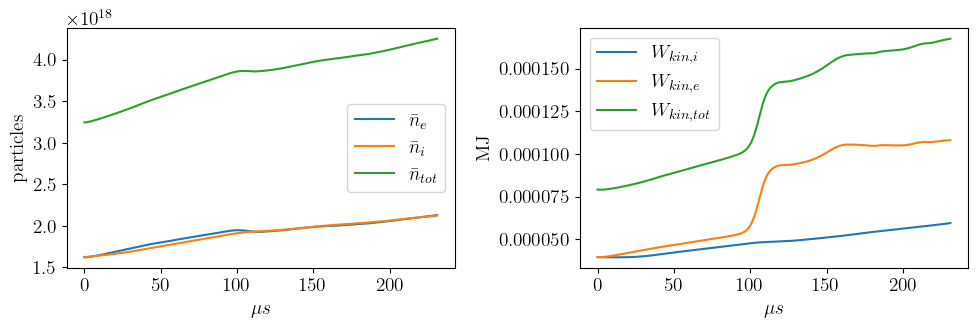

In [8]:
fieldnames = [['ne','ni','ntot'],['Wi','We','Wtot']] # this is for Bimaxwellian moments
time = pygkyl.plot_utils.plot_integrated_moment(simulation,fieldnames=fieldnames,ddt=False,twindow=[])

One can also check the integrated Hamiltonian and boundary fluxes if we are using a recent version of gkylzero (March 2025).

In [9]:
# fieldnames = [['ne','ni','ntot'],['He','Hi','Htot']]
# time = pygkyl.plot_utils.plot_integrated_moment(simulation,fieldnames=fieldnames, ddt=True)
# fieldnames = [['bflux_x_l_ntot','bflux_x_u_ntot','bflux_z_l_ntot','bflux_z_u_ntot','bflux_total_ntot'],
#               ['bflux_x_l_Htot','bflux_x_u_Htot','bflux_z_l_Htot','bflux_z_u_Htot','bflux_total_Htot']]
# time = pygkyl.plot_utils.plot_integrated_moment(simulation,fieldnames=fieldnames, ddt=True)

### 2.1 Profile relaxation <a id="1d_profile"></a>
Plot 1D cuts for multiple time frames.
- `cut_direction`   The dimension that remains after the cut. Can be 'x','y','z' and 'ky'.
- `cut_coords`      The coordinate of the cut, can be a double corresponding to the physical position (in the normalized units defined above), an integer to select an index or 'avg' to average over the dimension.
- `fieldnames`      The fields we want to plot. An array of char will create a multi plot. (see simulation.display_available_fields())
- `frames`          The frames to plot


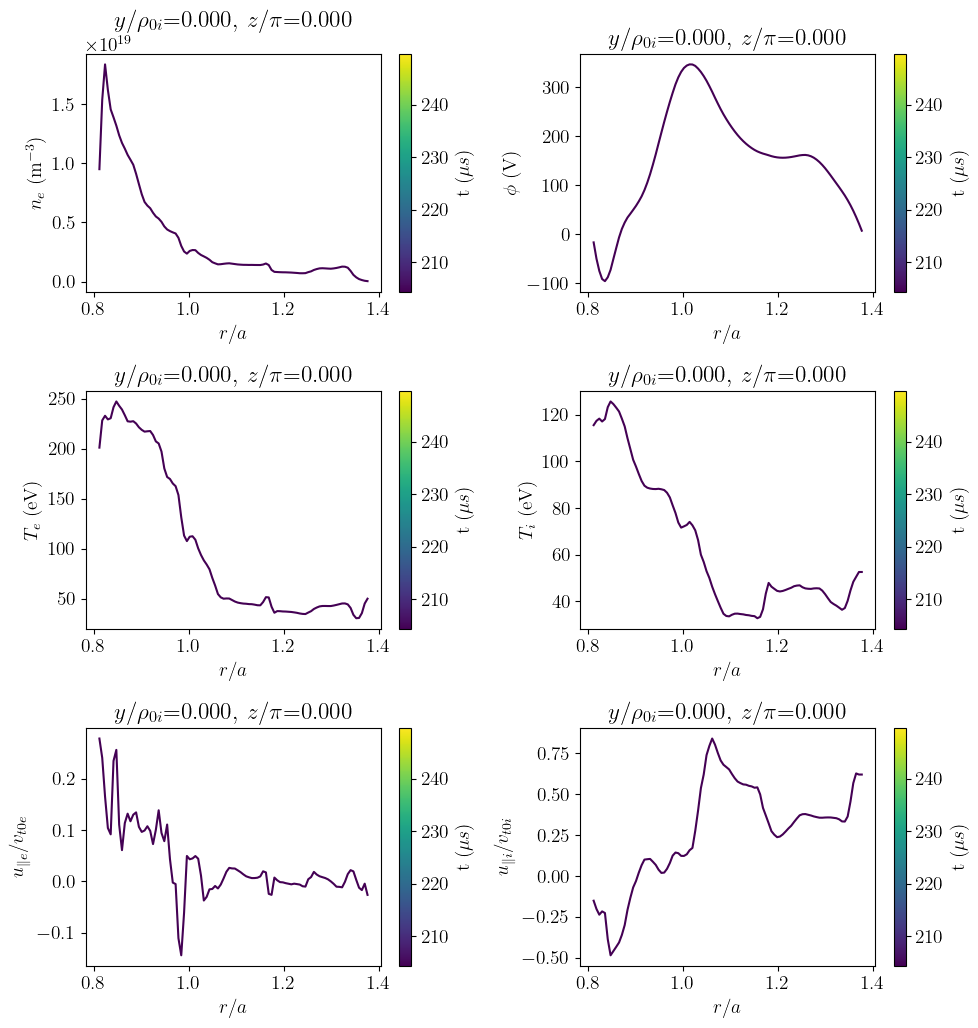

In [10]:
cut_direction='x' 
cut_coords=[0.0,0.0]
fieldnames = ['ne','phi','Te','Ti','upare','upari']
frames = sim_frames[-5]
pygkyl.plot_utils.plot_1D_time_evolution(simulation,cut_direction,cut_coords,fieldnames,frames,space_time = False)

### 2.2 Space-Time Diagrams <a id="space_time"></a>
Generate space-time diagrams for specified fields. Very useful to see the dynamics without a movie

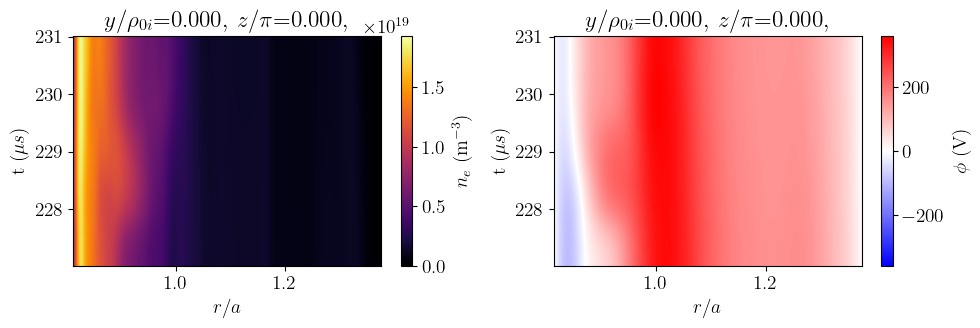

In [11]:
cut_dir = 'x'
cut_coord = [0.0, 0.0]
fieldnames = ['ne', 'phi']
frames = sim_frames[-5:]
figout = []
pygkyl.plot_utils.plot_1D_time_evolution(simulation, cut_dir, cut_coord, fieldnames, frames, space_time=True, plot_type='imshow', figout=figout)
# figout[0].savefig('ne_phi_space_time.png', dpi=300, bbox_inches='tight') # if you want to save the figure

### 2.3 Two-dimensional Cut <a id="2d_cut"></a>
Generate a 2D cut plot at a specified plane and time frame.

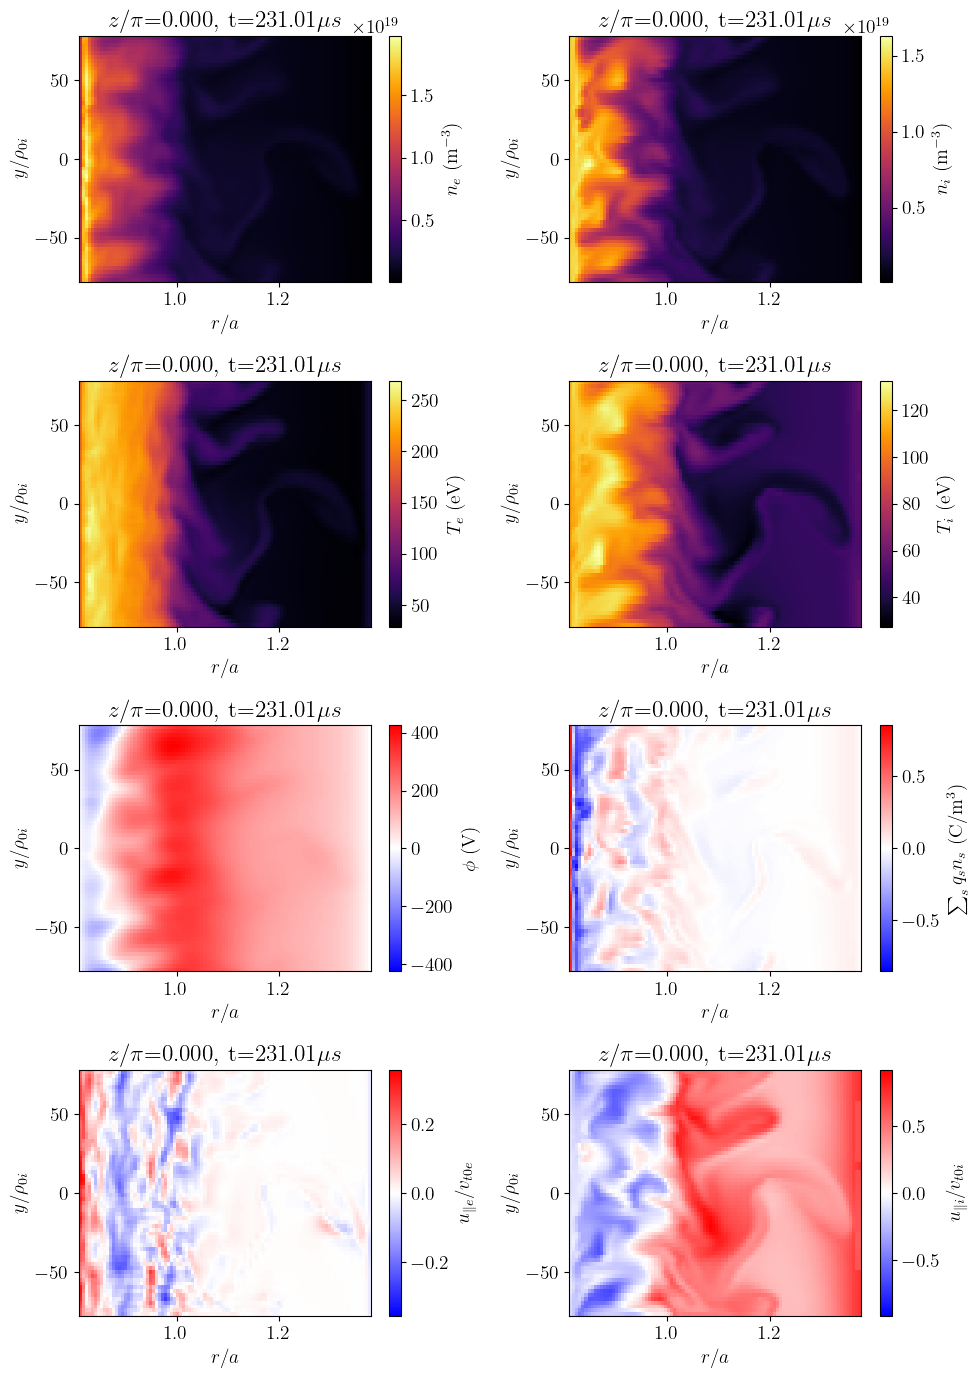

In [12]:
cut_dir = 'xy' # the plane we want to plot
cut_coord = 0.0 # the coordinate were the plan stands If normalized units are defined, 
# this number is in the normalize units. One can also specify a integer for array index 
# or 'avg' to get an average over the reduced dim.
time_frame = sim_frames[-1] # the time frame
fieldnames = ['ne', 'ni', 'Te', 'Ti', 'phi', 'qdens', 'upare', 'upari'] # the fields to plot, see simulation.display_available_fields() (some may not work in 2x2v)
pygkyl.plot_utils.plot_2D_cut(simulation, cut_dir, cut_coord, time_frame,fieldnames,plot_type='pcolormesh')

### 2.4 Space Time and 2D cut Fluctuation <a id="st_fluct_plot"></a>
Generate a fluctuation plot by averaging over a time window and then substracting this average to each time frame. The average is performed against time only. If `coords` is set to be 'avg', additional averages are performed for both background and fluctuations.

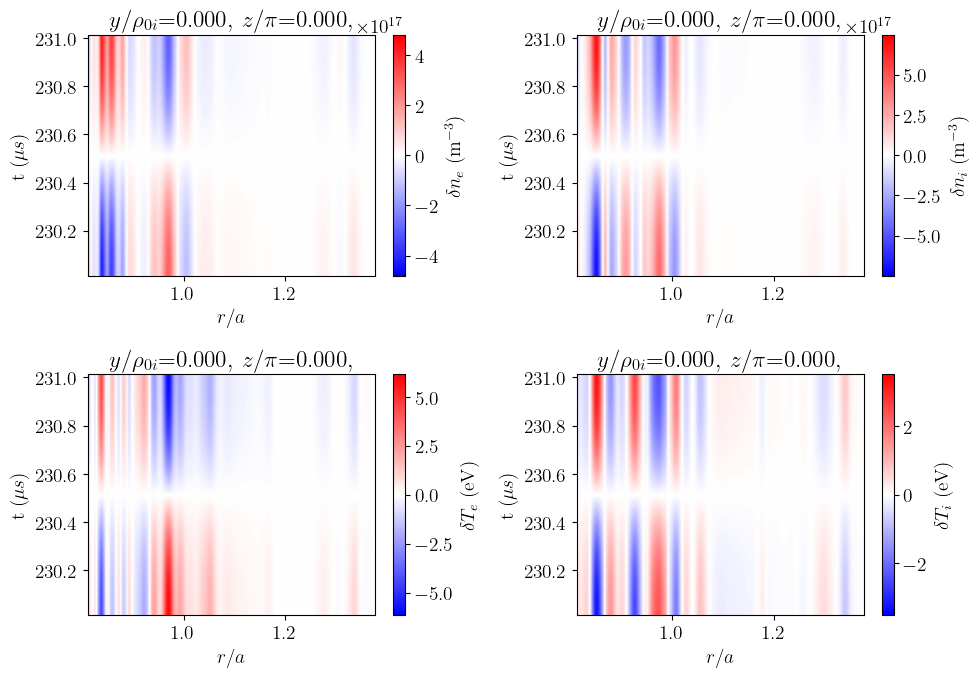

In [13]:
cut_direction='x' 
cut_coords=[0.0,0.0]
fieldnames = ['ne','ni','Te','Ti']
frames = sim_frames[-2:]
pygkyl.plot_utils.plot_1D_time_evolution(
    simulation,cut_direction,cut_coords,fieldnames,frames,
    space_time = True, fluctuation = True,plot_type='imshow')

### 2.5 Two-Dimensional Fluctuation <a id="2d_fluct_plot"></a>
Display the fluctuation of a field on a 2D plane
We can set `fluctuation='opt1_opt2'` where `opt1` can be 'tavg' or 'yavg', for fluctuation to the time average or the y average respectively. `opt2` can be 'relative' to have a relative fluctuation in percents.

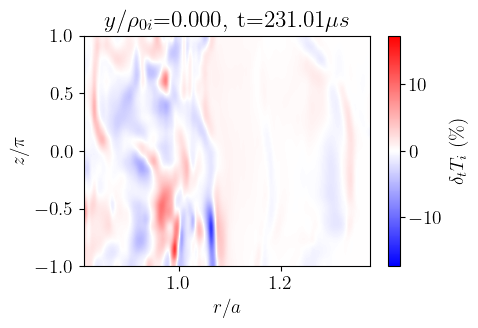

In [14]:
cplane='xz' 
ccoord = 0.0
frames = sim_frames[-2:]
fieldnames = ['Ti']
pygkyl.plot_utils.plot_2D_cut(
    simulation, cplane, ccoord, frames, fieldnames,
    time_average = False, fluctuation = 'tavg_relative',plot_type='imshow')

### 2.6 Time-Averaged Profile  <a id="time_averaged_profile"></a>
Here we show the ExB shear averaged over time of the last 50 frames. We generate also error bars that are related to the standard deviation.

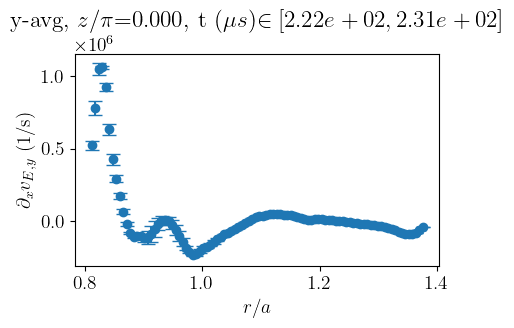

In [15]:
cdirection='x'
ccoords=['avg',0.0]
fieldnames = ['sExBy_x']
time_frames = sim_frames[-10:]
pygkyl.plot_utils.plot_1D(
    simulation,cdirection,ccoords,fieldnames,
    time_frames, errorbar = True,)

### 2.7 Movie Generator <a id="movie_generator"></a>
Create a first movie of 2D cuts over time and a second of the fluctuations over the last 25 frames

In [16]:
cut_dir = 'xz'
cut_coord = 0.0
time_frames = sim_frames[-2:]
fieldnames = ['Ti']
movieprefix = 'gallery/example_movie'
pygkyl.plot_utils.make_2D_movie(simulation, cut_dir=cut_dir, cut_coord=cut_coord, 
                                time_frames=time_frames, fieldnames=fieldnames, 
                                movieprefix=movieprefix, plot_type='imshow')

Processing frames: 2/2... 
Creating movie gallery/example_movie_Ti_y=0.00.gif...
movie gallery/example_movie_Ti_y=0.00.gif created.


We can also make a movie of fluctuations. The background is the average of the values during the movie time.

In [17]:
cut_dir = 'xy'
cut_coord = 0.0
time_frames = sim_frames[-2:]
fluctuation = True
fieldnames = ['Ti']
movieprefix = 'gallery/example_movie_fluct'
pygkyl.plot_utils.make_2D_movie(simulation, cut_dir=cut_dir, cut_coord=cut_coord, 
                                time_frames=time_frames, fieldnames=fieldnames, 
                                fluctuation=fluctuation, movieprefix=movieprefix, plot_type='imshow')

Processing frames: 2/2... 
Creating movie gallery/example_movie_fluct_dTi_z=0.00.gif...
movie gallery/example_movie_fluct_dTi_z=0.00.gif created.


### 2.8 Flux Surface Time-Average Profiles <a id="fs_time_averaged_profile"></a>
We also add a small example on how to save the figure. You can replot it by following the example in `pygkyl/examples/load_figout.py`.

fig_profiles.pkl saved.


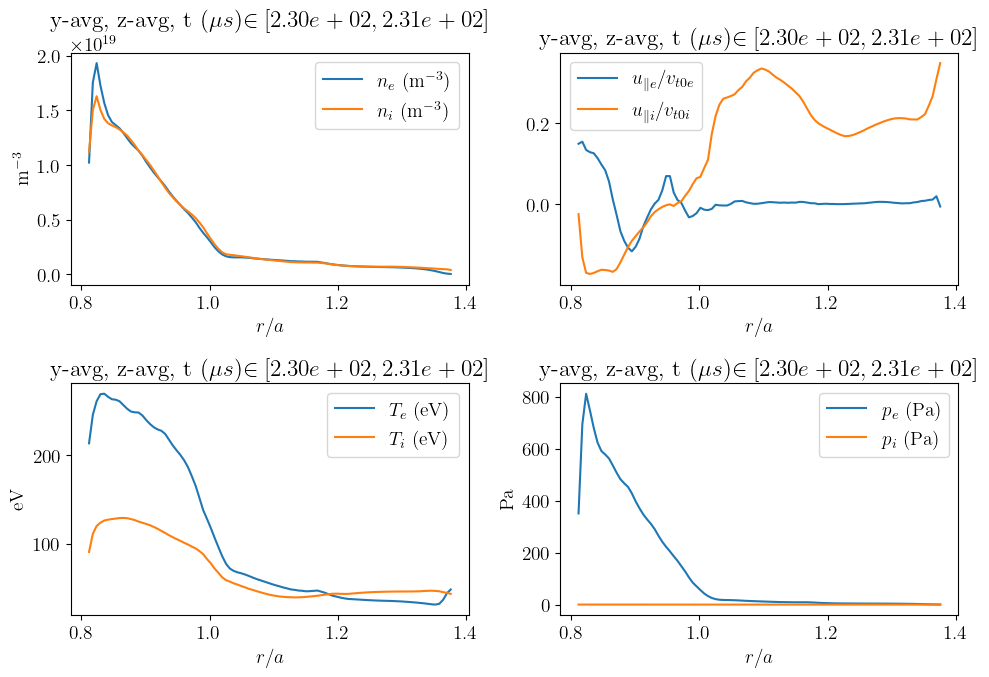

In [18]:
figout = []
cdirection='x'; ccoords=['avg','avg']
pygkyl.plot_utils.plot_1D(
        simulation,cdirection,ccoords,
        fieldnames = [['ne','ni'],['upare','upari'],
                      ['Te','Ti'],['pe','pi'],
                #       'qdens','phi',
                #       ['ExB_hflux_xe','ExB_hflux_xi'], ['Wtote','Wtoti']
                     ],
        time_frames = sim_frames[-2:], errorbar = False, figout = figout
        )
pygkyl.fig_tools.save_figout(figout,'fig_profiles') # this allows you to reload and replot with additional data

### 2.9 Time series <a id="time_series"></a>


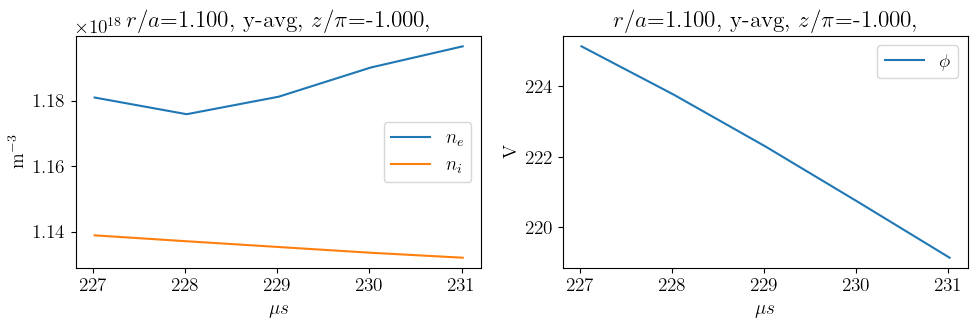

In [19]:
fieldnames = [['ne','ni'],'phi']
cut_coords = [1.1,'avg',0]
time_frames = sim_frames[-5:]
pygkyl.plot_utils.plot_time_serie(simulation,fieldnames,cut_coords,time_frames)

### 2.10 Phase Space Analysis <a id="dist_funct"></a>
This is done manually directly with the pgkyl routines. The distribution function files are usually very slow to load.

In [20]:
#---------- 2D cuts of a frame of the distribution function (long to load)
if False: #set it to true if you have some dist function data
    import postgkyl as pg
    import copy
    # Simulation frame for dist. func.
    fieldname = 'ion' #e.g. we check the electrostatic field files.
    f_frames = pygkyl.file_utils.find_available_frames(simulation,fieldname)
    tf = f_frames[-1]
    # Point where each cuts intersect [in Gkeyll units or indices]
    xf = '0.025'
    yf = '0.0'
    zf = '0.0'
    vf = '0.0'
    mf = '0.0'
    # Note: On Perlmutter, I had to copy the file
    #   postgkyl/src/postgkyl/output/postgkyl.mplstyle
    # to the local directory the postgkyl output files to be able to load them
    #   /global/u1/a/ah1032/.local/lib/python3.11/site-packages/postgkyl/output
    for spec in simulation.species.values():
        #---- Load the distf
        fname = simulation.get_filename('f'+spec.nshort,tf)
        data = pg.data.GData(fname)
        dg = pg.data.GInterpModal(data,1,'ms')
        dg.interpolate(0,overwrite=True)

        #---------------- 2D vpar x plots
        cut = copy.copy(data)
        pg.data.select(data=cut, z1=yf, z2=zf, z4=mf, overwrite=True)
        pg.output.plot(cut, yscale=1./spec.vt,
                    title=r"y=%s, z=%s, $\mu$=%s, t=%2.2e (s)"%(yf,zf,mf,data.ctx['time']),
                    contour=False,diverging=False, xshift=-simulation.geom_param.x_LCFS,
                    xlabel=r'$R-R_{lcfs}\,(m)$',ylabel=r'$v_\parallel/v_{th%s}$'%spec.nshort,
                    clabel=r'$f_{%s}$'%spec.nshort);

        #---------------- 2D mu x plots
        cut = copy.copy(data)
        pg.data.select(cut, z1=yf, z2=zf, z3=vf, overwrite=True)
        pg.output.plot(cut, yscale=1./spec.mu0,
                    title=r"y=%s, z=%s, $v_\parallel$=%s, t=%2.2e (s)"%(yf,zf,mf,data.ctx['time']),
                    contour=False,diverging=False, xshift=-simulation.geom_param.x_LCFS,
                    xlabel=r'$R-R_{lcfs}\,(m)$',ylabel=r'$\mu B/T_{%s}$'%spec.nshort,
                    clabel=r'$f_{%s}$'%spec.nshort);

        #---------------- 2D vpar mu plots
        cut = copy.copy(data)
        pg.data.select(cut, z0=xf, z1=yf, z2=zf, overwrite=True)
        pg.output.plot(cut, yscale=1./spec.mu0,
                    title=r"x=%s, y=%s, z=%s, t=%2.2e (s)"%(xf,yf,zf,data.ctx['time']),
                    contour=False,diverging=False, xshift=-simulation.geom_param.x_LCFS,
                    xlabel=r'$v_\parallel/v_{th%s}$'%spec.nshort,ylabel=r'$\mu B/T_{%s}$'%spec.nshort,
                    clabel=r'$f_{%s}$'%spec.nshort);

### 2.11 DG representation <a id="dg_rep"></a>
Plot the data in the DG form with cells and segments (1D only)

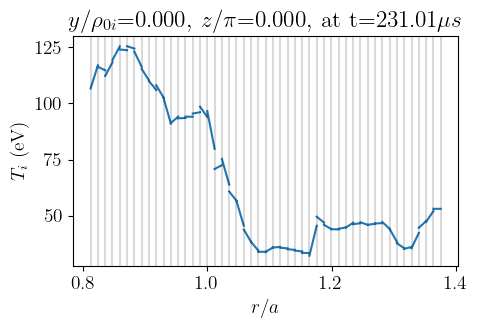

In [21]:
fieldname = 'Ti'
sim_frame = sim_frames[-1]
cutdir = 'x'
cutcoord = [0.0, 0.0]
xlim = []
pygkyl.plot_utils.plot_DG_representation(simulation, fieldname, sim_frame, cutdir, cutcoord, xlim)

### 2.12 Poloidal projection plot <a id="pol_plot"></a>
Project the flux tube on a poloidal plane (play with `nzInterp` to change resolution vs comp. time).

First we declare a poloidal projection object and set it up (declaring it upfront spares some run time as it can be reused for different plots.)

In [22]:
polproj = pygkyl.PoloidalProjection()
polproj.setup(simulation,nzInterp=24)

Now we can plot different fields like the ion pressure in a logarithmic scale:

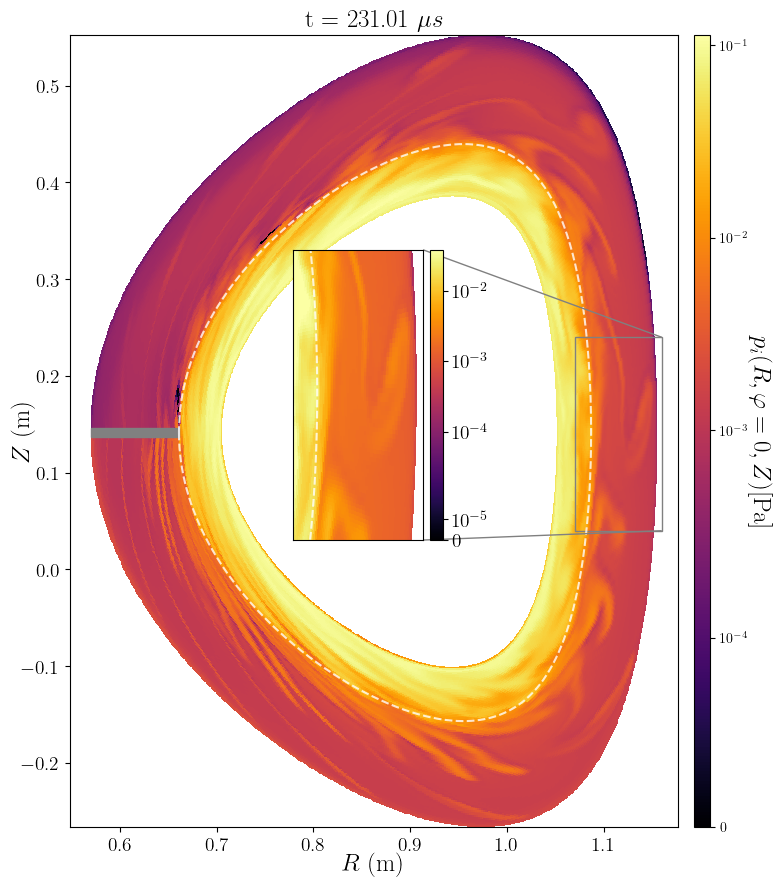

In [23]:
polproj.plot('pi',timeFrame=sim_frames[-1],colorScale='log',clim=[])

We can also plot the fluctuations (also available for movies)

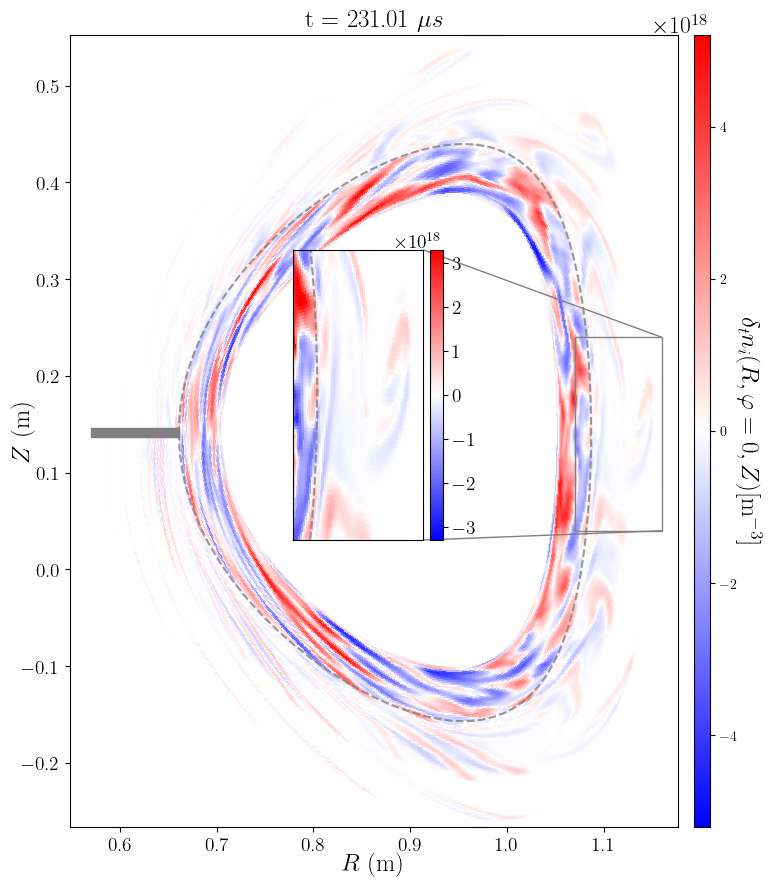

In [24]:
polproj.plot('ni',timeFrame=sim_frames[-10:],fluctuation='tavg')

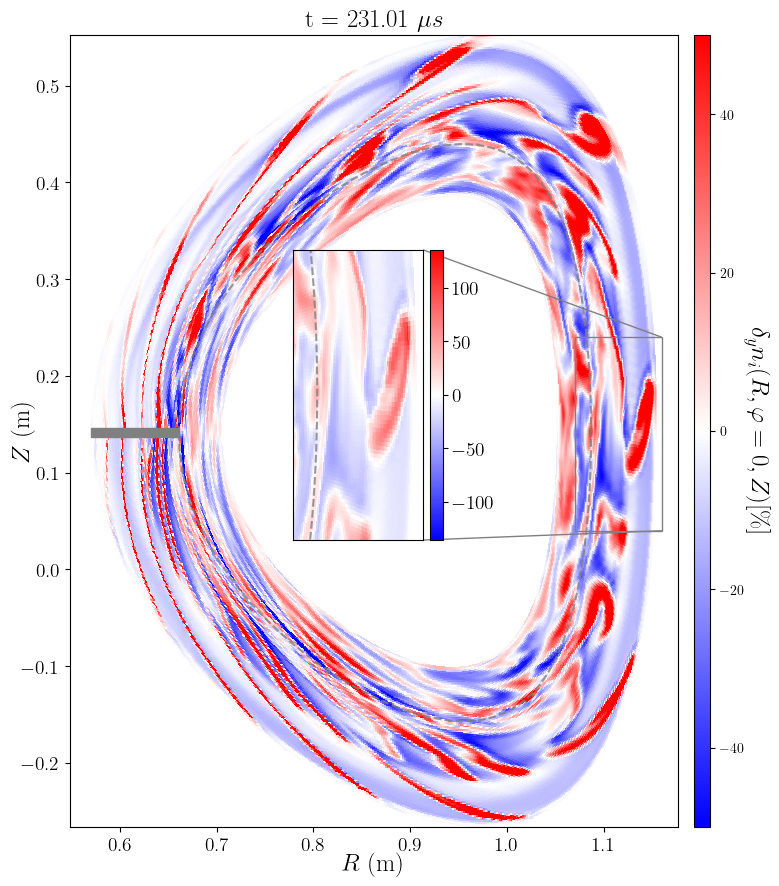

In [25]:
polproj.plot('ni',timeFrame=sim_frames[-1],fluctuation='relative_yavg',clim=[-50,50])

Or the radial component of the gradB drift
(here we also show how to customize the inset)

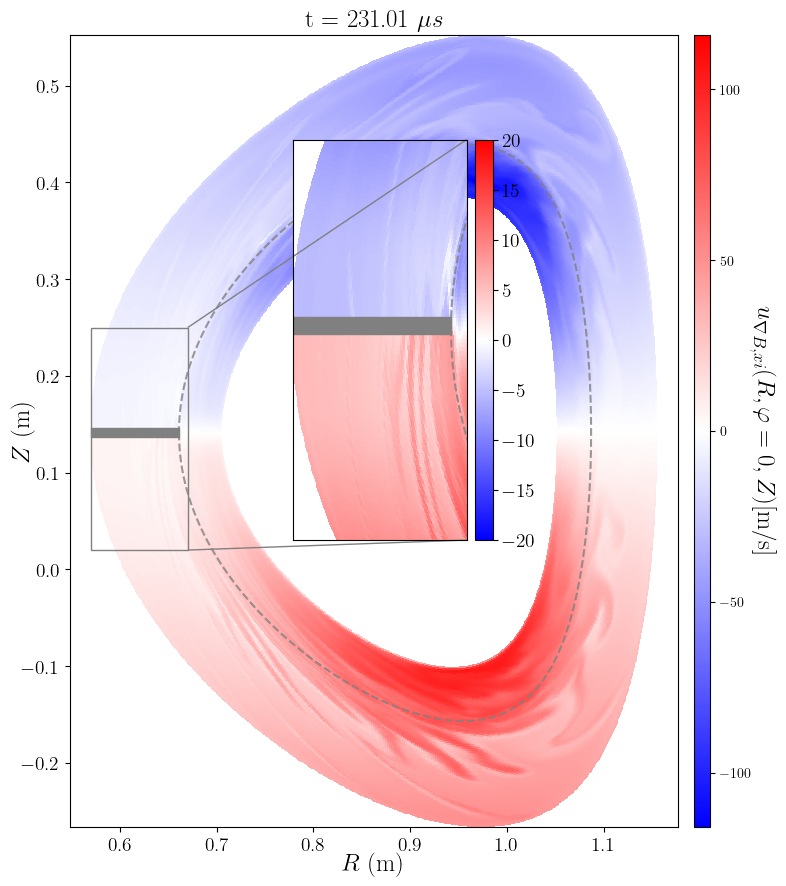

In [26]:
polproj.inset.zoom = 1.8 # adjust the zoom of the inset
polproj.inset.xlim = [0.57,0.67] # set the x-axis limits of the inset
polproj.inset.ylim = [0.02,0.25] # set the y-axis limits of the inset
polproj.inset.markloc = [2,3] # provide the corner to mark the inset (1 low L, 2 low R, 3 up L, 4 up R)
polproj.inset.lower_corner_rel_pos = (0.3,0.3) # set the relative position of the inset on the main plot
climInset = [-20,20] # custom colorbar limits for the inset plot
polproj.plot('gradBxB_xi',timeFrame=sim_frames[-1],climInset=climInset)
polproj.reset_inset() # reset the inset to the default values

It is possible to plot the projection only in a provided radial interval.

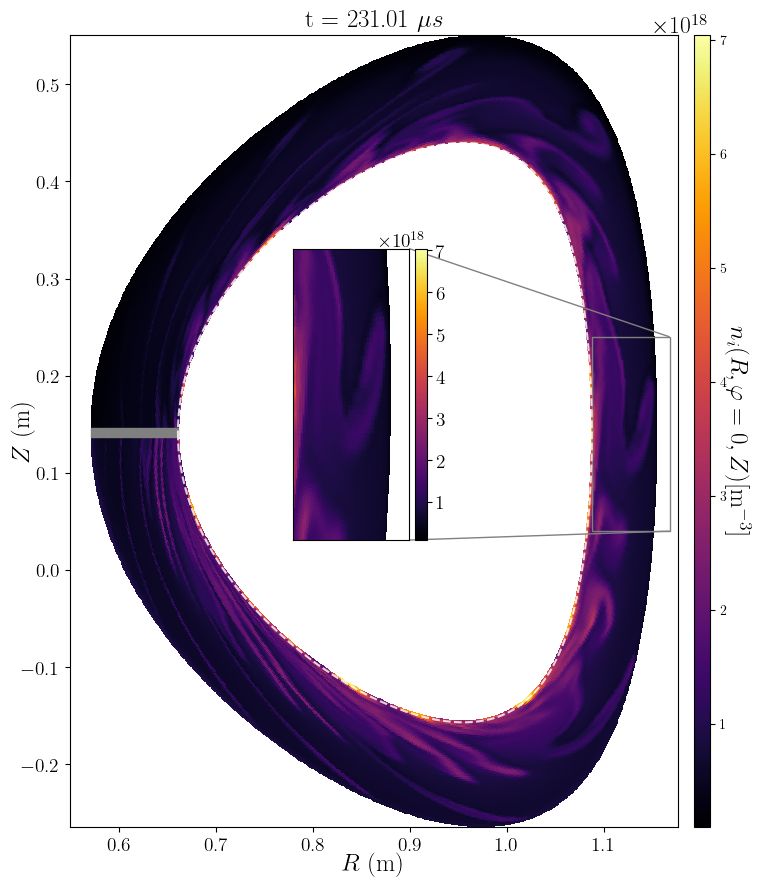

In [27]:
polproj = pygkyl.PoloidalProjection()
 # Here we use rho=r/a but we can also use Rlim for specifying the major radius limits.
polproj.setup(simulation,nzInterp=24,rholim=[1.0,1.5])
fieldname = 'ni'
timeFrame = sim_frames[-1]
polproj.inset.xlim = [simulation.geom_param.R_LCFSmid, simulation.geom_param.Rmid_max]
polproj.plot('ni',timeFrame=sim_frames[-1],colorScale='linear',clim=[],fluctuation='')

You can also create a movie of the poloidal projection

In [28]:
polproj.movie('pi',moviePrefix='gallery/mov_example_',timeFrames=sim_frames[-5:],colorScale='log')

Processing frames: 5/5... 
Creating movie gallery/mov_example_logpi_RZ.gif...
movie gallery/mov_example_logpi_RZ.gif created.


### 2.13 Flux surface projection plot <a id="fs_plot"></a>
Project the flux tube on a flux surface.

In [29]:
fsproj = pygkyl.FluxSurfProjection()

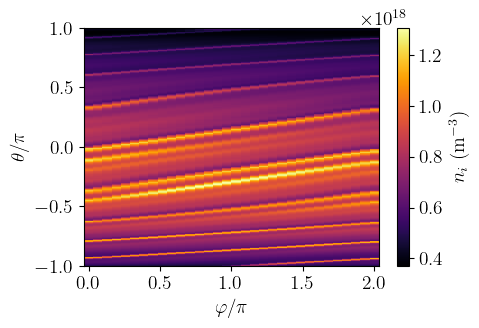

In [30]:
fieldname = 'ni'
rho = 1.2
Nint = 32
overSampFact = 2
timeFrame = sim_frames[-10]
fsproj.setup(simulation, Nint=Nint, rho=rho, smooth=True)
fsproj.plot(fieldName=fieldname, timeFrame=timeFrame, fluctuation='')

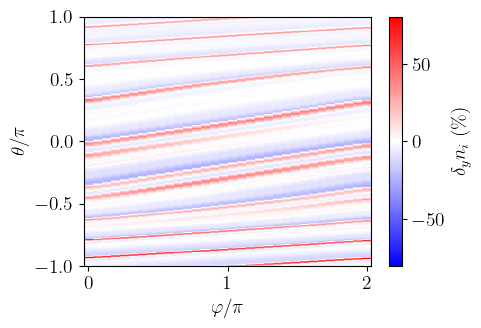

In [31]:
fsproj.plot(fieldName=fieldname, timeFrame=timeFrame, fluctuation='yavg_relative')

### 2.14 Toroidal projection plot <a id="tor_plot"></a>
Project the flux tube on the tokamak geometry

In [32]:
torproj = pygkyl.TorusProjection()
torproj.setup(simulation, 
              Nint_polproj=24, # number of interpolation points for the poloidal projection
              Nint_fsproj=32, # number of points along the toroidal direction
              phiLim = [0, 3*3.14/2], 
              rhoLim = [1,-4]
              )

In [36]:
fieldname = 'ni'
timeFrame = sim_frames[-1]
logScale = True
clim = [1e17,2e19]
outfilename = ''
torproj.plot(fieldName=fieldname, timeFrame=timeFrame, colorbar=True,
             fluctuation='',clim=clim, logScale = logScale,
             vessel=True, outFilename=outfilename, imgSize=(800,600))

Widget(value='<iframe src="http://localhost:54701/index.html?ui=P_0x364a06d20_2&reconnect=auto" class="pyvista…

In [ ]:
fieldname = 'ni'
timeFrames = sim_frames[-2:]
fluctuation = ''
logScale = True
clim = [3e17,3e19]
fileprefix = ''

torproj.movie(fieldName=fieldname, timeFrames=timeFrames, 
              fluctuation=fluctuation, clim=clim, logScale=logScale, 
              vessel=True, filePrefix=fileprefix, imgSize=(800,600))

Processed frames: 2/2... 
Movie saved as test_torproj_movie_ni.gif
